![](https://images.squarespace-cdn.com/content/v1/61d8b320b69665709c730b42/3ed0a4b0-d655-438f-9dfb-0675f3744eb3/B+Logo+for+White+Background+%28Use+on+%23FFFFFF%29.png?format=150w)

# [MDplus Datathon 2024](http://ai.mdplus.community/datathon/2024)

Welcome to the 2024 MDplus Datathon! We're so excited to have you participate in this year's datathon. The goal of this Python notebook is three fold:

  1. **Learn** the basics of Python and how we can easily use programming as a tool to interact with and analyze medical data. **No prior Python experience is required or expected!**
  2. **Understand** and interact with the clinical dataset(s) curated for this year's datathon.
  3. **Write** a simple function to ask a large language model (like ChatGPT) a question using Python code.

Have any questions? Ask a question in the `#datathon-2024` MDplus Slack channel!

[Python](https://www.w3schools.com/python/) is a general-purpose, user-friendly programming language that can be used for a variety of different tasks, including analyzing clinical datasets.

While Python code is built to be easy to read and write, writing your own code to parse through datasets, multiply numbers, and other mundane tasks can be a waste of time. Instead, the Python community has already written a lot of helpful tools and functions for us to use for these tasks! These tools and functions are organized into ***packages***. We can use a Python package manager called `pip` to download some packages that are relevant for us:

In [ ]:
# To run a code block like this one, press the "Play" button on the left hand
# side or press [Shift + Enter] on your keyboard while this code block is
# selected.
!pip install -U datasets ipywidgets together --quiet

Now that we've downloaded these packages, we also need to import them for us to use. The keyword `import` in Python tells your computer to import the packages and all of their helpful functions and tools for us to use here.

In [ ]:
import datasets
import os
import requests
from google.colab import userdata, output
from ipywidgets import widgets
from together import Together
from typing import Any, Dict

output.enable_custom_widget_manager()

In this year's datathon, we have three separate tracks for you and your team to participate in depending on your interests.

  1. Medical Education
  2. Clinical Documentation
  3. Mental Health

Each of these tracks have their own datasets associated with them. The following code block will download the dataset that's relevant for you depending on your track. The code itself is likely more sophisticated than what you'll need for your project, so we don't recommend worrying too much about this code block. However, if you're interested we've also commented descriptions of what the code is doing. Comments (starting with the `#` character) are just notes for humans to better understand your code, and are invisible to your computer.

More information on the datasets can be found here: https://huggingface.co/datasets/mdplus/Datathon2024

In [ ]:
# TRACK_OPTIONS is a "dictionary" that maps certain values to other values. In
# this case, our dictionary below maps the names of the Datathon tracks (e.g.,
# Medication Eduction) to the ID of the dataset in the Datathon (e.g., meded).
TRACK_OPTIONS = {
    "Medical Education": "meded",
    "Clinical Documentation": "clindoc",
    "Mental Health": "mentalhealth"
}

# TRACK is a variable that stores what track you and your team will be
# participating in.
TRACK = list(TRACK_OPTIONS.keys())[2]

# We'll create a user-friendly widget for your to be able to select your
# track that you're participating in. We create this widget using the
# Dropdown object from the `widgets` package.
track_selection = widgets.Dropdown(
    options=TRACK_OPTIONS.keys(),
    description="Track:",
    value=TRACK
)

# This is a helper function that we'll use to update the value of the
# TRACK variable depending on what you select from the dropdown widget.
# No need to look too closely at this function.
def on_change(change: Dict[str, Any]) -> None:
    global TRACK
    if change["type"] == "change" and change["name"] == "value":
        TRACK = change["new"]
    return

# Here, we're telling Dropdown widget to update the TRACK variable depending
# on the widget value.
track_selection.observe(on_change)

# Use the widget to select your Datathon track!
display(track_selection)

Dropdown(description='Track:', index=2, options=('Medical Education', 'Clinical Documentation', 'Mental Health…

After selecting your Datathon track from the Dropdown widget above, we can now load the dataset associated with your specific track. All of the datasets for all three tracks can be found at [this link](https://huggingface.co/datasets/mdplus/Datathon2024/tree/main). However, manually downloading these datasets can be difficult - our datasets are quite small, but other datasets you encounter in real life can be a lot bigger!

Instead, let's use the Python `datasets` package to download our track's dataset. We'll use the `load_dataset()` function to download the dataset and save it as a variable called `ds`. We've already split your dataset into training and test splits - you should use the training split to train any models or algorithms you develop, and the test split to evaluate your project.

In [ ]:
# You might get a warning about the `HF_TOKEN` not existing in your Colab
# secrets. Don't worry about this for now for the purposes of this tutorial!
ds = datasets.load_dataset("mdplus/Datathon2024", data_dir=TRACK_OPTIONS[TRACK])
train_dataset = ds["train"].to_pandas()
test_dataset = ds["test"].to_pandas()

What does the training dataset look like? Let's take a look!

In [ ]:
train_dataset

,text,label
0,wanting to skip or postpone my exam my exam is...,anxiety
1,Do other bipolar folks have problems with subs...,bipolar
2,Wanted to share some revelations I just had to...,depression
3,I feel deader than dead. I find that I don't h...,suicide_watch
4,I'm pretty sure my friends suicidal what do I ...,suicide_watch
...,...,...
43524,I stopped Lamictal after it screwed up my visi...,bipolar
43525,I'm afraid my ex committed suicide what do I d...,suicide_watch
43526,Failed college 2 times it was +10 years ago. I...,depression
43527,Put on some music that you find beautiful and ...,anxiety


# Data Preprocessing

In [ ]:
# Load both datasets
train_df = train_dataset
test_df = test_dataset

print("Training Dataset Shape:", train_df.shape)
print("\
Training Dataset Label Distribution:")
print(train_df['label'].value_counts())

print("\
Test Dataset Shape:", test_df.shape)
print("\
Test Dataset Label Distribution:")
print(test_df['label'].value_counts())

Training Dataset Shape: (43529, 2)
Training Dataset Label Distribution:
label
depression       14972
suicide_watch     8164
anxiety           7644
off_my_chest      6597
bipolar           6152
Name: count, dtype: int64
Test Dataset Shape: (10883, 2)
Test Dataset Label Distribution:
label
depression       3774
suicide_watch    2018
anxiety          1911
off_my_chest     1687
bipolar          1493
Name: count, dtype: int64


In [ ]:
import re

def clean_text(text):
    # Remove special characters and extra whitespace, convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    return text.strip().lower()

# Apply the cleaning function to the 'text' column in both datasets
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

# Display the first few rows of the cleaned training data
print(train_df[['cleaned_text', 'label']].head())

# Display the first few rows of the cleaned test data
print(test_df[['cleaned_text', 'label']].head())

                                        cleaned_text          label
0  wanting to skip or postpone my exam my exam is...        anxiety
1  do other bipolar folks have problems with subs...        bipolar
2  wanted to share some revelations i just had to...     depression
3  i feel deader than dead i find that i dont hav...  suicide_watch
4  im pretty sure my friends suicidal what do i d...  suicide_watch
                                        cleaned_text          label
0  suicidal but wont do it just need someone to t...  suicide_watch
1  a lie a lie ruined my life a lie a lie ruined ...   off_my_chest
2  suicidal thoughts and venting i would first li...  suicide_watch
3  guided meditation disclaimer i am in no way sa...        bipolar
4  effexor day 1 is going badly good news so the ...        anxiety


In [ ]:
# prompt: remove rows the the 'label' of 'off_my_chest' for both the train_df and test_df

train_df = train_df[train_df['label'] != 'off_my_chest']
test_df = test_df[test_df['label'] != 'off_my_chest']

# Feature Extraction

## TF-IDF (Sparse Vectorization)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)

# Fit and transform the training data, transform the test data
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['cleaned_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['cleaned_text'])

# Display the shape of the TF-IDF vectorized data
print("Training data shape (TF-IDF):", X_train_tfidf.shape)
print("Test data shape (TF-IDF):", X_test_tfidf.shape)

Training data shape (TF-IDF): (36932, 10000)
Test data shape (TF-IDF): (9196, 10000)


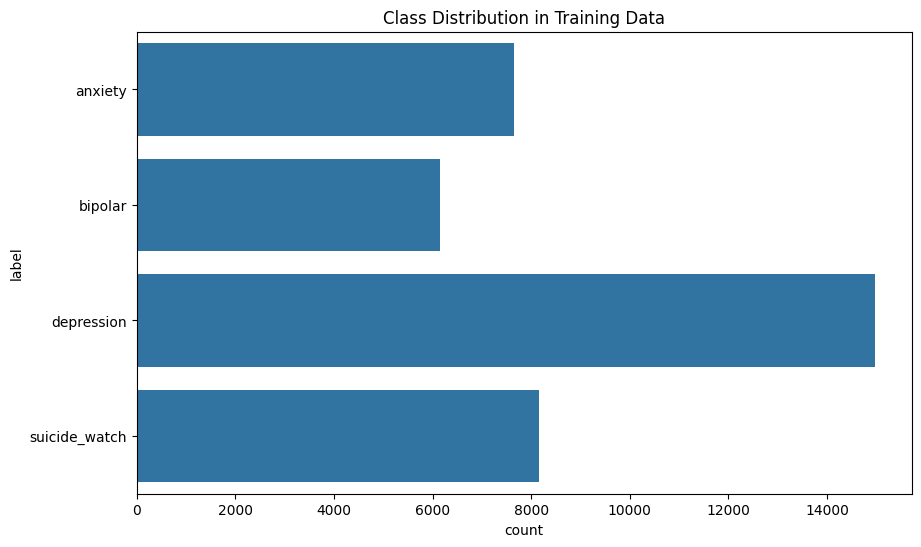

Class Weights:
anxiety: 1.208
bipolar: 1.501
depression: 0.617
suicide_watch: 1.131


In [ ]:
# First, let's visualize the class imbalance
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, y='label')
plt.title('Class Distribution in Training Data')
plt.show()

# Calculate the class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced',
                                   classes=train_df['label'].unique(),
                                   y=train_df['label'])
weights_dict = dict(zip(train_df['label'].unique(), class_weights))
print("\
Class Weights:")
for label, weight in weights_dict.items():
    print(f"{label}: {weight:.3f}")

## Word2Vec
https://www.kaggle.com/code/sugataghosh/e-commerce-text-classification-tf-idf-word2vec

In [ ]:
import re
from nltk.corpus import stopwords
import gensim
from gensim.models import Word2Vec
import multiprocessing

In [ ]:
!pip install gdown

In [ ]:
import gdown

# Download weights from official source; mirror: https://github.com/mmihaltz/word2vec-GoogleNews-vectors
file_id = "0B7XkCwpI5KDYNlNUTTlSS21pQmM"
url = f"https://drive.google.com/uc?id={file_id}&confirm=t"
target_download_path = "/content/GoogleNews-vectors-negative300.bin.gz"

# Download the file, if it hasn't already been downloaded
if not os.path.exists(target_download_path):
  gdown.download(url, target_download_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&confirm=t
To: /content/GoogleNews-vectors-negative300.bin.gz
100%|██████████| 1.65G/1.65G [00:37<00:00, 44.2MB/s]


In [ ]:
!gunzip -f /content/GoogleNews-vectors-negative300.bin.gz

In [ ]:
# Loading the pre-trained Word2Vec model
word2vec_path = '/content/GoogleNews-vectors-negative300.bin'
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary = True)



In [ ]:
import numpy as np

# Word2Vec functions from https://www.kaggle.com/code/rajmehra03/a-complete-text-classfication-guide-word2vec-lstm
def get_average_word2vec(tokens_list, vector, generate_missing = False, k = 300):
    if len(tokens_list) < 1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis = 0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, tokens, generate_missing = False):
    embeddings = tokens.apply(lambda x: get_average_word2vec(x, vectors, generate_missing = generate_missing))
    return list(embeddings)

In [ ]:
X_train_embed = np.vstack(get_word2vec_embeddings(word2vec, train_df['cleaned_text']))
X_test_embed = np.vstack(get_word2vec_embeddings(word2vec, test_df['cleaned_text']))


In [ ]:
# Inspect shape

print(f"Shape of X_train_embed: {X_train_embed.shape, len(X_train_embed)}")
print(f"Shape of X_test_embed: {X_test_embed.shape, len(X_test_embed)}")

Shape of X_train_embed: ((36932, 300), 36932)
Shape of X_test_embed: ((9196, 300), 9196)


# Resampling

In [ ]:
%pip install -U imbalanced-learn
from imblearn.over_sampling import SMOTE
import pandas as pd


# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
# 1 - Apply SMOTE to TF-IDF data
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, train_df['label'])

# 2 - Apply SMOTE to Word2Vec embeddings
X_train_embed_balanced, y_train_embed_balanced = smote.fit_resample(X_train_embed, train_df['label'])

In [ ]:
# Display the new class distribution
print("Balanced Training Data Shape:", X_train_balanced.shape)
print("\
Balanced Class Distribution for TF-IDF:")
print(pd.Series(y_train_balanced).value_counts())

print("Balanced Training Data Shape (Word2Vec):", np.vstack(X_train_embed_balanced).shape)

print("\
Balanced Class Distribution for Word2Vec:")
print(pd.Series(y_train_embed_balanced).value_counts())


Balanced Training Data Shape: (59888, 10000)
Balanced Class Distribution for TF-IDF:
label
anxiety          14972
bipolar          14972
depression       14972
suicide_watch    14972
Name: count, dtype: int64
Balanced Training Data Shape (Word2Vec): (59888, 300)
Balanced Class Distribution for Word2Vec:
label
anxiety          14972
bipolar          14972
depression       14972
suicide_watch    14972
Name: count, dtype: int64


In [ ]:
# Since SMOTE is the same order; they should be the same
(y_train_embed_balanced == y_train_balanced).value_counts()

,count
label,
True,59888


## Classification Model Training

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Analyze a viable subset of the dataset
# X_train_balanced, _, y_train_balanced, _ = train_test_split(X_train_balanced, y_train_balanced, train_size=0.8, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_balanced)
y_test_encoded = label_encoder.transform(test_df['label'])


# Initialize models
rf_model = RandomForestClassifier(n_jobs=-1, random_state=42)
svm_model = SVC(probability=True, random_state=42)
logreg_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
xgb_model = XGBClassifier(
    learning_rate=0.05,
    n_estimators=500,
    max_depth=5,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    reg_alpha=0.5,
    reg_lambda=1,
    objective='binary:logistic',  # or 'multi:softmax' for multiclass
    eval_metric='logloss',  # suitable for classification
    use_label_encoder=False,
    n_jobs=-1
)

In [ ]:
from datetime import datetime

In [ ]:
import copy

train_feature_sets = {
    'TF-IDF': X_train_balanced,
    'Word2Vec': X_train_embed_balanced
}

test_feature_sets = {
    'TF-IDF': X_test_tfidf,
    'Word2Vec': X_test_embed
}

models = {
    'Random Forest': rf_model,
    'Logistic Regression': logreg_model,
    'XGBoost': xgb_model
}

trained_models = {}

# Binarize labels for AUROC
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(test_df['label'])

# Fraction to use for training
fraction = 1

# For each feature set, train each model to determine which is best performing
for feature_set_name, X_train_fset in train_feature_sets.items():
  if fraction != 1:
    if hasattr(X_train_fset, "shape"):  # Works for both sparse matrices and numpy arrays
        subset_size = int(X_train_fset.shape[0] * fraction)
    else:
        subset_size = int(len(X_train_fset) * fraction)

    # Create the subset of data
    X_train_subset = X_train_fset[:subset_size]
    y_train_subset = y_train_encoded[:subset_size]
  else:
    X_train_subset = X_train_fset
    y_train_subset = y_train_encoded

  for model_name, model in models.items():
    print(f"[{feature_set_name}] Training {model_name} model on {feature_set_name} feature set... ({datetime.now()})")
    model.fit(X_train_subset, y_train_subset)

    combined_model_name = f"{feature_set_name}_{model_name}"

    trained_models[combined_model_name] = copy.deepcopy(model)

    print(f"Saved model {combined_model_name} to data dictionary.")

# Evaluate the accuracy, F1 score and binary AUROC for each multi-class classification model
results = {} # modelname_featureset: dict of F1 score, AUROC, accuracy


[TF-IDF] Training Random Forest model on TF-IDF feature set... (2024-11-13 10:36:37.413963)
Saved model TF-IDF_Random Forest to data dictionary.
[TF-IDF] Training Logistic Regression model on TF-IDF feature set... (2024-11-13 10:37:54.462192)
Saved model TF-IDF_Logistic Regression to data dictionary.
[TF-IDF] Training XGBoost model on TF-IDF feature set... (2024-11-13 10:38:03.309119)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:38:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Saved model TF-IDF_XGBoost to data dictionary.
[Word2Vec] Training Random Forest model on Word2Vec feature set... (2024-11-13 10:47:08.733526)
Saved model Word2Vec_Random Forest to data dictionary.
[Word2Vec] Training Logistic Regression model on Word2Vec feature set... (2024-11-13 10:47:41.520261)
Saved model Word2Vec_Logistic Regression to data dictionary.
[Word2Vec] Training XGBoost model on Word2Vec feature set... (2024-11-13 10:47:54.776453)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:47:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Saved model Word2Vec_XGBoost to data dictionary.


In [ ]:
print(test_feature_sets.keys())
print(trained_models.keys())

# For each trained_model, print expected inputs/outputs
for model_name, model in trained_models.items():
    print(f"\nModel: {model_name}")
    try:
        # Check if the model has a n_features_in_ attribute (common in scikit-learn models)
        if hasattr(model, "n_features_in_"):
            n_features = model.n_features_in_
            print(f"Expected number of features for {model_name}: {n_features}")

            # Optionally, you can test prediction with a dummy input
            sample_input = np.random.rand(1, n_features)
            model.predict(sample_input)
            print(f"Sample input shape {sample_input.shape} is compatible with {model_name}")
        else:
            print(f"{model_name} does not have 'n_features_in_' attribute; input format may need manual inspection.")
    except Exception as e:
        print(f"Error encountered for {model_name} with dummy input: {e}")

dict_keys(['TF-IDF', 'Word2Vec'])
dict_keys(['TF-IDF_Random Forest', 'TF-IDF_Logistic Regression', 'TF-IDF_XGBoost', 'Word2Vec_Random Forest', 'Word2Vec_Logistic Regression', 'Word2Vec_XGBoost'])

Model: TF-IDF_Random Forest
Expected number of features for TF-IDF_Random Forest: 10000
Sample input shape (1, 10000) is compatible with TF-IDF_Random Forest

Model: TF-IDF_Logistic Regression
Expected number of features for TF-IDF_Logistic Regression: 10000
Sample input shape (1, 10000) is compatible with TF-IDF_Logistic Regression

Model: TF-IDF_XGBoost
Expected number of features for TF-IDF_XGBoost: 10000
Sample input shape (1, 10000) is compatible with TF-IDF_XGBoost

Model: Word2Vec_Random Forest
Expected number of features for Word2Vec_Random Forest: 300
Sample input shape (1, 300) is compatible with Word2Vec_Random Forest

Model: Word2Vec_Logistic Regression
Expected number of features for Word2Vec_Logistic Regression: 300
Sample input shape (1, 300) is compatible with Word2Vec_Logisti

In [ ]:
trained_models.keys()

dict_keys(['TF-IDF_Random Forest', 'TF-IDF_Logistic Regression', 'TF-IDF_XGBoost', 'Word2Vec_Random Forest', 'Word2Vec_Logistic Regression', 'Word2Vec_XGBoost'])

In [ ]:
# pickle and save models
import pickle

# Pickle entire trained_models dict consisting of pairs of model_name: model
with open('trained_models.pkl', 'wb') as f:
    pickle.dump(trained_models, f)

## Proceed with Evaluation

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from datetime import datetime
from sklearn.utils import resample
from tqdm import tqdm

# Parameters for bootstrapping
n_bootstraps = 1000
confidence_level = 0.95

# Initialize dictionary to store results with confidence intervals
bootstrapped_results = {}

for feature_set_name, X_test_fset in test_feature_sets.items():
    for combined_model_name, model in trained_models.items():
        if feature_set_name not in combined_model_name:
            print(f"[Warning] Skipping combination {combined_model_name} and fset {feature_set_name} (not valid).")
            continue

        print(f"Running predictions for {combined_model_name} model and {feature_set_name} feature set... [{datetime.now()}]")

        # Get y_pred (changed from ordinal categories back into str)
        y_pred = label_encoder.inverse_transform(model.predict(X_test_fset))
        y_proba = model.predict_proba(X_test_fset)

        # Store bootstrapped metrics
        accuracy_scores = []
        auroc_scores = []
        f1_scores = []
        precision_scores = []
        recall_scores = []

        # ROC curve data
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)  # Common FPR range for interpolation

        for i in tqdm(range(n_bootstraps), desc=f"Bootstrapping {combined_model_name} on {feature_set_name}"):
            # Resample with replacement
            X_resampled, y_resampled = resample(X_test_fset, test_df['label'], random_state=i)
            y_resampled_binarized = label_encoder.transform(y_resampled)

            # Make predictions on resampled data
            y_pred_resampled = label_encoder.inverse_transform(model.predict(X_resampled))
            y_proba_resampled = model.predict_proba(X_resampled)

            # Calculate metrics
            accuracy_scores.append(accuracy_score(y_resampled, y_pred_resampled))
            auroc_scores.append(roc_auc_score(y_resampled_binarized, y_proba_resampled, multi_class='ovr'))
            f1_scores.append(f1_score(y_resampled, y_pred_resampled, average='weighted'))
            precision_scores.append(precision_score(y_resampled, y_pred_resampled, average='weighted'))
            recall_scores.append(recall_score(y_resampled, y_pred_resampled, average='weighted'))

        # Calculate confidence intervals
        def calculate_confidence_interval(data):
            lower_bound = np.percentile(data, ((1 - confidence_level) / 2) * 100)
            upper_bound = np.percentile(data, (1 - (1 - confidence_level) / 2) * 100)
            return np.mean(data), (lower_bound, upper_bound)

        bootstrapped_results[combined_model_name] = {
            'Accuracy': calculate_confidence_interval(accuracy_scores),
            'AUROC': calculate_confidence_interval(auroc_scores),
            'F1 Score': calculate_confidence_interval(f1_scores),
            'Precision': calculate_confidence_interval(precision_scores),
            'Recall': calculate_confidence_interval(recall_scores)
        }

# Print the results with confidence intervals
for model_name, metrics in bootstrapped_results.items():
    print(f"\nResults for {model_name}:")
    for metric_name, (mean_score, ci) in metrics.items():
        print(f"{metric_name}: {mean_score:.4f} (95% CI: {ci[0]:.4f} - {ci[1]:.4f})")


Running predictions for TF-IDF_Random Forest model and TF-IDF feature set... [2024-11-13 10:57:52.684933]


Bootstrapping TF-IDF_Random Forest on TF-IDF: 100%|██████████| 1000/1000 [08:10<00:00,  2.04it/s]


Running predictions for TF-IDF_Logistic Regression model and TF-IDF feature set... [2024-11-13 11:06:03.228319]


Bootstrapping TF-IDF_Logistic Regression on TF-IDF: 100%|██████████| 1000/1000 [03:48<00:00,  4.38it/s]


Running predictions for TF-IDF_XGBoost model and TF-IDF feature set... [2024-11-13 11:09:51.574293]


Bootstrapping TF-IDF_XGBoost on TF-IDF: 100%|██████████| 1000/1000 [14:07<00:00,  1.18it/s]


[Warning] Skipping combination Word2Vec_Random Forest and fset TF-IDF (not valid).
[Warning] Skipping combination Word2Vec_Logistic Regression and fset TF-IDF (not valid).
[Warning] Skipping combination Word2Vec_XGBoost and fset TF-IDF (not valid).
[Warning] Skipping combination TF-IDF_Random Forest and fset Word2Vec (not valid).
[Warning] Skipping combination TF-IDF_Logistic Regression and fset Word2Vec (not valid).
[Warning] Skipping combination TF-IDF_XGBoost and fset Word2Vec (not valid).
Running predictions for Word2Vec_Random Forest model and Word2Vec feature set... [2024-11-13 11:23:59.784582]


Bootstrapping Word2Vec_Random Forest on Word2Vec: 100%|██████████| 1000/1000 [06:33<00:00,  2.54it/s]


Running predictions for Word2Vec_Logistic Regression model and Word2Vec feature set... [2024-11-13 11:30:33.489894]


Bootstrapping Word2Vec_Logistic Regression on Word2Vec: 100%|██████████| 1000/1000 [04:48<00:00,  3.47it/s]


Running predictions for Word2Vec_XGBoost model and Word2Vec feature set... [2024-11-13 11:35:21.902543]


Bootstrapping Word2Vec_XGBoost on Word2Vec: 100%|██████████| 1000/1000 [07:13<00:00,  2.31it/s]


Results for TF-IDF_Random Forest:
Accuracy: 0.6836 (95% CI: 0.6744 - 0.6928)
AUROC: 0.8648 (95% CI: 0.8594 - 0.8708)
F1 Score: 0.6852 (95% CI: 0.6761 - 0.6945)
Precision: 0.6889 (95% CI: 0.6798 - 0.6982)
Recall: 0.6836 (95% CI: 0.6744 - 0.6928)

Results for TF-IDF_Logistic Regression:
Accuracy: 0.7091 (95% CI: 0.7000 - 0.7187)
AUROC: 0.9026 (95% CI: 0.8980 - 0.9072)
F1 Score: 0.7100 (95% CI: 0.7009 - 0.7196)
Precision: 0.7128 (95% CI: 0.7037 - 0.7223)
Recall: 0.7091 (95% CI: 0.7000 - 0.7187)

Results for TF-IDF_XGBoost:
Accuracy: 0.7093 (95% CI: 0.7003 - 0.7182)
AUROC: 0.8962 (95% CI: 0.8913 - 0.9009)
F1 Score: 0.7110 (95% CI: 0.7020 - 0.7197)
Precision: 0.7206 (95% CI: 0.7121 - 0.7294)
Recall: 0.7093 (95% CI: 0.7003 - 0.7182)

Results for Word2Vec_Random Forest:
Accuracy: 0.4460 (95% CI: 0.4354 - 0.4560)
AUROC: 0.6807 (95% CI: 0.6729 - 0.6882)
F1 Score: 0.4457 (95% CI: 0.4349 - 0.4557)
Precision: 0.4461 (95% CI: 0.4353 - 0.4562)
Recall: 0.4460 (95% CI: 0.4354 - 0.4560)

Results for W

In [ ]:
results.keys()

dict_keys([])

In [ ]:
# Print out results, for each model/feature set pair

for model_fset_pair, stats in results.items():
  print("---")
  print(f"Model/Feature Set: {model_fset_pair}")
  for metric, value in stats.items():
    print(f"{metric}: {value}")
  print("---")


In [ ]:
# Plot AUROC curve for best feature set - Logistic Regression has highest F1 score
best_model_name = "TF-IDF_Logistic Regression"
best_feature_set_name = "TF-IDF"

best_model = trained_models[best_model_name]
curr_test_feature_set = test_feature_sets[best_feature_set_name]

# Perform inference on test set
y_pred = label_encoder.inverse_transform(best_model.predict(curr_test_feature_set))
y_proba = best_model.predict_proba(curr_test_feature_set)

# Binarize labels for AUROC
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(test_df['label'])

class_mapping = {index: label for index, label in enumerate(lb.classes_)}

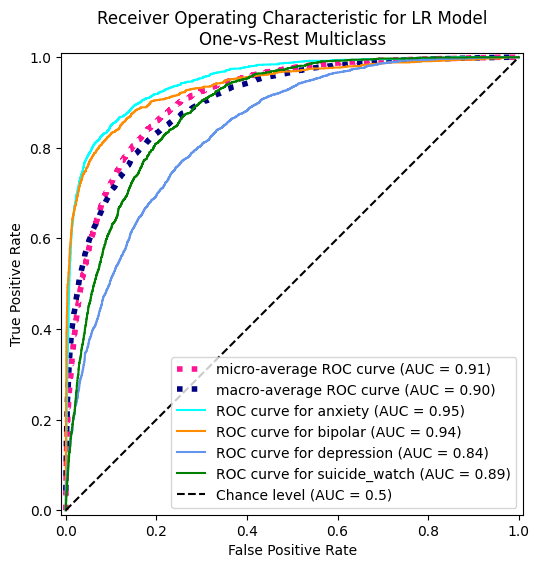

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from itertools import cycle
import numpy as np

# Initialize the false positive rate, true positive rate, and AUC dictionaries
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# Aggregate all FPR and TPR scores across all classes
all_fpr = np.unique(np.concatenate([roc_curve(y_test_binarized[:, i], y_proba[:, i])[0] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average TPR and compute AUC for macro-average
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot the figure
fig, ax = plt.subplots(figsize=(6, 6))

# Plot micro-average ROC curve
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

# Plot macro-average ROC curve
plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

# Cycle through colors for each class
colors = cycle(["aqua", "darkorange", "cornflowerblue", "green", "purple"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_test_binarized[:, class_id],
        y_proba[:, class_id],
        name=f"ROC curve for {class_mapping[class_id]}",
        color=color,
        ax=ax,
        plot_chance_level=(class_id == n_classes - 1),  # Chance level plot for the last class
    )

# Configure plot aesthetics
ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Receiver Operating Characteristic for LR Model\nOne-vs-Rest Multiclass",
)
ax.legend(loc="lower right")

# Save to PDF
output_path = "OvR_ROC_Curves.pdf"
plt.savefig(output_path, format="pdf")

plt.show()


# Ensemble (Stack) using XGBoost meta-model

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import numpy as np
from xgboost import XGBClassifier

# Meta-model initialization
meta_model = XGBClassifier()

# Train base models (already done in your provided code), so use `trained_models`

# Generate meta-features from the base models' predictions
# Initialize containers for stacking features and labels
meta_train_features = []
meta_test_features = []

# Generate meta-features on training data
for feature_set_name, X_train_fset in train_feature_sets.items():
  if "TF-IDF" in feature_set_name:
    train_preds = []
    for model_name, model in models.items():
        combined_model_name = f"{feature_set_name}_{model_name}"

        # Ensure the model has already been trained and saved
        if combined_model_name in trained_models:
            print(f"Generating training meta-features with {combined_model_name}...")
            # Get prediction probabilities for the training set
            train_preds.append(trained_models[combined_model_name].predict_proba(X_train_fset))

    # Stack predictions from all base models as features for the meta-model
    meta_train_features.append(np.hstack(train_preds))

# Concatenate meta-features across all feature sets for training
meta_train_features = np.hstack(meta_train_features)

# Meta-labels (original training labels)
meta_train_labels = y_train_encoded

# Hyperparameter grid for the meta-model (XGBoost)
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Initialize GridSearchCV for the meta-model
grid_search = GridSearchCV(meta_model, param_grid, scoring='f1_weighted', cv=5, verbose=1, n_jobs=-1)

# Train the meta-model with hyperparameter tuning
print("Tuning and training the meta-model (XGBoost) on stacked features...")
grid_search.fit(meta_train_features, meta_train_labels)

# Best meta-model
best_meta_model = grid_search.best_estimator_
print(f"Best meta-model parameters: {grid_search.best_params_}")

# Generate meta-features on the test data
for feature_set_name, X_test_fset in test_feature_sets.items():
  if "TF-IDF" in feature_set_name:
    test_preds = []
    for model_name, model in models.items():
        combined_model_name = f"{feature_set_name}_{model_name}"

        # Use trained models to generate test predictions
        if combined_model_name in trained_models:
            print(f"Generating test meta-features with {combined_model_name}...")
            # Get prediction probabilities for the test set
            test_preds.append(trained_models[combined_model_name].predict_proba(X_test_fset))

    # Stack predictions from all base models as features for the meta-model
    meta_test_features.append(np.hstack(test_preds))

# Concatenate meta-features across all feature sets for testing
meta_test_features = np.hstack(meta_test_features)

# Make final predictions with the best meta-model
stacked_predictions = best_meta_model.predict(meta_test_features)
stacked_proba = best_meta_model.predict_proba(meta_test_features)


Generating training meta-features with TF-IDF_Random Forest...
Generating training meta-features with TF-IDF_Logistic Regression...
Generating training meta-features with TF-IDF_XGBoost...
Tuning and training the meta-model (XGBoost) on stacked features...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best meta-model parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Generating test meta-features with TF-IDF_Random Forest...
Generating test meta-features with TF-IDF_Logistic Regression...
Generating test meta-features with TF-IDF_XGBoost...

Tuned Stacked Model Performance:
Accuracy: 0.6406
F1 Score: 0.6424
AUROC: 0.8043


In [ ]:
# Evaluate the stacked model
accuracy = accuracy_score(y_test_encoded, stacked_predictions)
f1 = f1_score(y_test_encoded, stacked_predictions, average='weighted')
auroc = roc_auc_score(y_test_binarized, stacked_proba, multi_class='ovr')

print(f"\nTuned Stacked Model Performance:\nAccuracy: {accuracy:.4f}\nF1 Score: {f1:.4f}\nAUROC: {auroc:.4f}")

TypeError: got an unexpected keyword argument 'average'

#LLM Integration

As you can see, the dataset is a table where each row is a datapoint, and each column is a variable. To learn more about how to programmatically work with the dataset, check out this short 10-minute tutorial on the python `pandas` package [here](https://pandas.pydata.org/docs/user_guide/10min.html).

In [ ]:
# # prompt: convert dataset into a csv

# import pandas as pd

# # Assuming 'train_dataset' and 'test_dataset' are already defined as pandas DataFrames
# # from the previous code.

# # Combine train and test datasets if you want to include all data in one CSV
# combined_dataset = pd.concat([train_dataset, test_dataset], ignore_index=True)

# # Save the combined dataset to a CSV file
# combined_dataset.to_csv('combined_dataset.csv', index=False)

# # Alternatively, save train and test datasets to separate CSV files:
# train_dataset.to_csv('train_dataset.csv', index=False)
# test_dataset.to_csv('test_dataset.csv', index=False)

Now that we have our dataset downloaded, what can we do with it? One option is to feed it into a Large Language Model (LLM)! An LLM is exactly what it sounds like - a machine learning model that takes text data as input, and can process text to answer any questions or perform tasks or instructions. There are a lot of LLMs out there now, including [ChatGPT](https://chatgpt.com/) and [Meta Llama 3.1](https://ai.meta.com/blog/meta-llama-3-1/).

Note that LLMs are also *large* - so large that it's very difficult or even possible to download these models and run on your own computer. Instead, companies like [Together AI](https://www.together.ai/) have dedicated supercomputers that will run any request or command that you have - all you need to do is pay a few cents per question you ask the LLM (see the pricing details [here](https://www.together.ai/pricing) if you're interested). Together AI also offers $5 in free API credits when you sign up, which should be more than enough to get started.

### **Important: Note that for the purposes of the Datathon, you may only use open-source models with 8-billion parameters or less if you're using an LLM as a part of your project.**

Let's try and run an LLM from Meta (previously Facebook) called Llama 3.1, which is offered by the Together AI platform. Follow these steps:

  1. Go to [together.ai](https://www.together.ai/) and click "Get Started" at the upper right. Create an account.
  2. Create an API key at [this link](https://api.together.xyz/settings/api-keys). An API key is a unique key that tells Together AI that it's you who is making a request to their servers. **[IMPORTANT]: Never share your API key with anyone!!**
  3. Copy your API key. In Google Colab, click on the "Secrets" icon on the toolbar on the left hand side of your screen (it should look like a key). Set the name of your API key to `TOGETHER_API_KEY` and paste the value of your API key to the "Value" field. Grant this Notebook access to this secret.

If all goes well, the following line of code should run without any errors.

In [ ]:
# WARNING: DO NOT SHARE YOUR API KEY WITH ANYONE!
os.environ["TOGETHER_API_KEY"] = userdata.get("TOGETHER_API_KEY")

To "log into" Together AI and verify your identity with its platform, we need to instantiate a "client" object to establish the relevant connection details between your computer and Together AI's servers. A lot of complicated stuff happens in the background, but for us, all we need to do is run the following line:

In [ ]:
llm_client = Together()

Normally when asking a question to a language model, we would type our question out in a search box and press [Enter], and the model's response would begin to show up on the screen. This is fine to do for general, everyday use, but what if you want to tell the language model to perform *thousands* of tasks? We can programatically ask LLMs questions using the code below.

Firstly, let's extract a sample input to the language model from your Datathon track dataset:

In [ ]:
# # Note that which column is selected depends on which dataset you loaded. Only
# # the Medical Education dataset has a "question" column, the Clinical Documen-
# # tation track a "dialogue" column, and the Mental Health track a "text" column.
# if TRACK == "Medical Education":
#     input_column_name = "question"
# elif TRACK == "Clinical Documentation":
#     input_column_name = "dialogue"
# else:
#     input_column_name = "text"

# sample_input = train_dataset.iloc[0][input_column_name]

# print(f"Input to LLM:\n{sample_input}")

We've saved the input to the language model as a variable `sample_input`. To feed this into the LLM and ask for a response, all we need to do is run the code below. In our example, we'll use the Llama 3.1 model from Meta for this demo.

****Warning**\**: Running this next block of code will cost a few cents from your free $5 API credits from your Together AI account.

In [ ]:
# # Asking the Together AI llm_client to respond to your instruction will cost
# # money! Be conscientious about any calls to llm_clients that you make.
# modelID = "meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo"
# completion = llm_client.chat.completions.create(
#     model=modelID,
#     messages=[{
#         "role": "user",
#         "content": sample_input
#     }],
# )

That's it! We've asked the model our question, and the LLM's response is saved as the `completion` variable. We can print out the LLM's response here:

In [ ]:
# print(completion.choices[0].message.content)

There's a lot more things you can do with models to alter their performance and behavior - you can check out the [Together AI documentation](https://docs.together.ai/docs/chat-overview) and also the [API reference](https://docs.together.ai/reference/completions-1) as a starting point. Prompt engineering is also an easy way to improve model performance; a good starting point is available [here](https://www.promptingguide.ai/).

## Frequently Asked Questions

  1. **Do I need to use LLMs for my datathon project?** No, feel free to use whatever technology(s) you want.
  2. **Do I need to use Python for my datathon project?** No, feel free to use whatever programming language you want.
  3. **What LLMs can I use?** The full list of LLMs offered by Together AI are available [here](https://docs.together.ai/docs/chat-models). Out of these options, you may use any model in the table below. Models that are bolded are generally recommended because they were released more recently and generally perform better than non-bolded models. Using any of these models is as sample as changing out the `model` parameter value in the `llm_client.chat.completions.create()` function call above:

```python
completion = llm_client.chat.completions.create(
    model="TODO: Model ID of the model you want to use",
    messages=[{
        "role": "user",
        "content": "TODO: Whatever input you want to pass into the model."
    }],
)
```

| Model Name | Model ID |
| :--------- | :------- |
| **Gemma Instruct (2B)** | `google/gemma-2b-it` |
| **Llama 3.2 3B Instruct Turbo** | `meta-llama/Llama-3.2-3B-Instruct-Turbo` |
| **Llama 3.1 8B Instruct Turbo** | `meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo` |
| Llama 3 8B Instruct Turbo | `meta-llama/Meta-Llama-3-8B-Instruct-Turbo` |
| **Mistral (7B) Instruct v0.3** | `mistralai/Mistral-7B-Instruct-v0.3` |
| Mistral (7B) Instruct v0.2 | `mistralai/Mistral-7B-Instruct-v0.2`	|
| Mistral (7B) Instruct | `mistralai/Mistral-7B-Instruct-v0.1` |
| **Qwen 2.5 7B Instruct Turbo** | `Qwen/Qwen2.5-7B-Instruct-Turbo` |
| **Together StripedHyena Nous (7B)** | `togethercomputer/StripedHyena-Nous-7B` |

  4. **Do I have to use Together AI?** No, you are welcome to use any LLM inference provider (or run models locally!). In our experience, Together AI is easy to use and costs the least amount of money. The only requirement is that any LLM used for the datathon must be both (1) at most 8 billion parameters; and (2) open-source. This means that models like ChatGPT and Anthropic's Claude models are not permitted.
  5. **How can I learn more about Python?** We've compiled some helpful resources [here](http://ai.mdplus.community/resources), and you can also check out last year's Python Tutorial [here](http://ai.mdplus.community/datathon/python#/title-slide). The best way to learn more is to start writing code, and ask questions in the `#datathon-2024` Slack channel!
  6. **Can I use generative AI tools and language models to help my team complete our project?** Yes, the use of generative AI tools are permitted to help you complete any parts of the project. However, you and your team are responsible for any and all outputs of generative AI tools.

# Example for Resource Generation

In [ ]:
# Example paragraph and preprocessing
example_text = "I used to love riding in elevators, now everytime i think about riding in elevators i breath very heavily, i freeze up, and can't think, and breth quickly, what's wrong with me? is it my fault?"

# Preprocess the text using the same TF-IDF vectorizer we used before
example_tfidf = tfidf_vectorizer.transform([example_text])

# Use the trained Logistic Regression model to predict
predicted_label = logreg_model.predict(example_tfidf)[0]
prediction_proba = logreg_model.predict_proba(example_tfidf)

# Get top 2 predictions
top_2_indices = prediction_proba[0].argsort()[-2:][::-1]
top_2_labels = logreg_model.classes_[top_2_indices]
top_2_probs = prediction_proba[0][top_2_indices]

print("Text:", example_text)
print("\
Top Predictions:")
print(f"1st: {top_2_labels[0]} (probability: {top_2_probs[0]:.3f})")
print(f"2nd: {top_2_labels[1]} (probability: {top_2_probs[1]:.3f})")

print("\
All Prediction Probabilities:")
for label, prob in zip(logreg_model.classes_, prediction_proba[0]):
    print(f"{label}: {prob:.3f}")

Text: I used to love riding in elevators, now everytime i think about riding in elevators i breath very heavily, i freeze up, and can't think, and breth quickly, what's wrong with me? is it my fault?
Top Predictions:
1st: off_my_chest (probability: 0.240)
2nd: depression (probability: 0.226)
All Prediction Probabilities:
anxiety: 0.178
bipolar: 0.190
depression: 0.226
off_my_chest: 0.240
suicide_watch: 0.166


In [ ]:
# Asking the Together AI llm_client to respond to your instruction will cost
# money! Be conscientious about any calls to llm_clients that you make.
modelID = "meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo"
completion = llm_client.chat.completions.create(
    model=modelID,
    messages=[{
        "role": "user",
        "content": f"generate resources for someone you suspect may be experiencing {top_2_labels[0]} and {top_2_labels[1]} and in a friendly manner"
    }],
)

In [ ]:
print(completion.choices[0].message.content)

I'm so glad you reached out for help. It takes a lot of courage to acknowledge when we're struggling, and I'm here to support you. If you're experiencing feelings of off-my-chest and depression, here are some resources that might be helpful:

**Hotlines and Support Lines:**

1. **National Suicide Prevention Lifeline (US):** 1-800-273-TALK (8255) - a 24/7 hotline that provides free and confidential support.
2. **Crisis Text Line (US):** Text HOME to 741741 - a 24/7 text line that connects you with a trained crisis counselor.
3. **Samaritans (UK):** 116 123 - a 24/7 helpline that provides emotional support.
4. **Lifeline (Australia):** 13 11 14 - a 24/7 crisis support and suicide prevention service.

**Online Resources:**

1. **Mental Health America:** A comprehensive website with information on mental health conditions, treatment options, and resources.
2. **National Alliance on Mental Illness (NAMI):** A website with information on mental health conditions, treatment options, and suppo